In [81]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
import torchvision
import random
import torch

import os

def set_seed(seed=1234):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [82]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Path to dataset files: /kaggle/input/human-face-emotions


In [83]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loader)

def train(model, trainloader, testloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss = validation(model, testloader, criterion)
        print(f'Epoch: {epoch + 1} | Training Loss: {running_loss / len(trainloader):.4f} | Validation Loss: {val_loss:.4f}')

def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return (corrected / total) * 100

def confusion_matrix(model, loader):
    model.eval()

    # pega os nomes das classes do ImageFolder
    class_names = base_dataset.classes          # ex.: ['Angry', 'Disgust', ...]
    num_classes = len(class_names)

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for true, pred in zip(labels, predicted):
                confusion_matrix[true.item(), pred.item()] += 1

    confusion_matrix = confusion_matrix.cpu().numpy()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        confusion_matrix,
        annot=True,
        cmap='Blues',
        fmt='g',
        xticklabels=class_names,   # <<< trocou aqui
        yticklabels=class_names    # <<< e aqui
    )
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')
    plt.title("Matriz de Confusão")
    plt.show()
    return ax


In [84]:
data_root = os.path.join(path, "Data")  # <<< ajuste importante
base_dataset = datasets.ImageFolder(data_root)

print("Classes encontradas:", base_dataset.classes)

# ---------- transforms ----------
img_size = (256, 256)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# ---------- split treino/teste ----------
torch.manual_seed(42)
train_size = int(0.8 * len(base_dataset))
test_size  = len(base_dataset) - train_size

train_subset, test_subset = random_split(
    base_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# ---------- mini-dataset debug ----------
MAX_TRAIN = 1000
MAX_TEST  = 300

max_train = min(MAX_TRAIN, len(train_subset))
max_test  = min(MAX_TEST,  len(test_subset))

torch.manual_seed(123)
train_idx = torch.randperm(len(train_subset))[:max_train]
test_idx  = torch.randperm(len(test_subset))[:max_test]

small_train_subset = Subset(train_subset, train_idx)
small_test_subset  = Subset(test_subset,  test_idx)

from collections import Counter

def contar_labels(subset):
    labels = []
    for i in range(len(subset)):
        _, label = subset[i]
        labels.append(label)
    return Counter(labels)

print("Distribuição no treino (debug):", contar_labels(small_train_subset))
print("Distribuição no teste  (debug):", contar_labels(small_test_subset))

print("\nÍndice -> nome da classe:")
for idx, name in enumerate(base_dataset.classes):
    print(idx, "->", name)

# ---------- wrapper + loaders ----------
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = SubsetWithTransform(small_train_subset, transform=transform_train)
test_dataset  = SubsetWithTransform(small_test_subset,  transform=transform_test)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

Classes encontradas: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
Distribuição no treino (debug): Counter({2: 317, 3: 213, 0: 173, 4: 149, 1: 148})
Distribuição no teste  (debug): Counter({2: 90, 3: 64, 0: 64, 4: 42, 1: 40})

Índice -> nome da classe:
0 -> Angry
1 -> Fear
2 -> Happy
3 -> Sad
4 -> Suprise


In [85]:
from collections import Counter

def contar_labels(subset):
    labels = []
    for i in range(len(subset)):
        _, label = subset[i]   # subset[i] = ( vb PIL_image, label)
        labels.append(label)
    return Counter(labels)

print("Distribuição no treino (debug):", contar_labels(small_train_subset))
print("Distribuição no teste  (debug):", contar_labels(small_test_subset))

print("\nÍndice -> nome da classe:")
for idx, name in enumerate(base_dataset.classes):
    print(idx, "->", name)


Distribuição no treino (debug): Counter({2: 317, 3: 213, 0: 173, 4: 149, 1: 148})
Distribuição no teste  (debug): Counter({2: 90, 3: 64, 0: 64, 4: 42, 1: 40})

Índice -> nome da classe:
0 -> Angry
1 -> Fear
2 -> Happy
3 -> Sad
4 -> Suprise


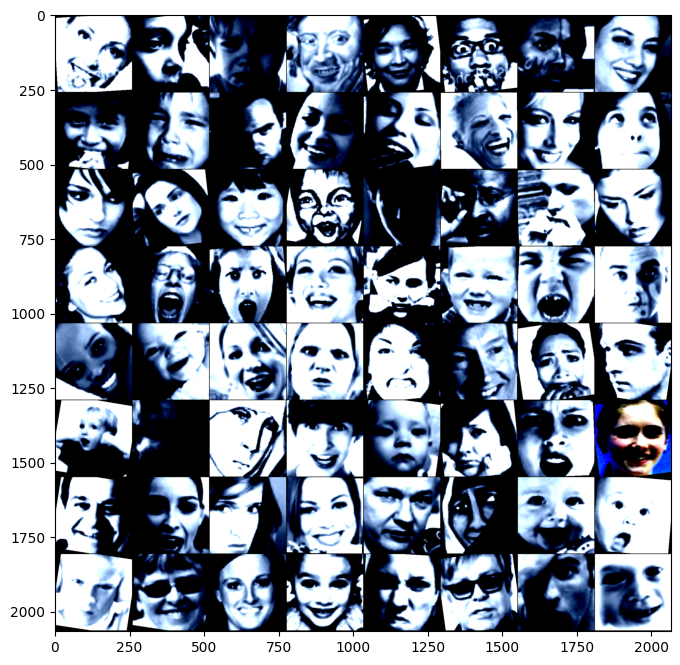

In [86]:
def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))

In [87]:
resnet = torchvision.models.resnet50(weights = torchvision.models.ResNet50_Weights.DEFAULT)

In [88]:
#resnet

In [89]:
# substituímos a última camada da rede para resolver o nosso problema de classificação
num_classes = len(base_dataset.classes)          # deve dar 5
in_features = resnet.fc.in_features              # em vez de "chutar" 2048

resnet.fc = nn.Linear(in_features, num_classes)
resnet = resnet.to(device)

In [90]:
#  resnet

In [91]:
# "congelamos os pesos das camadas, exceto a última"
for name, params in resnet.named_parameters():
    if name not in ('fc.weight', 'fc.bias'):
        params.requires_grad = False
# for name, params in resnet.named_parameters():
#     print(name, params.requires_grad)

In [92]:
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnet.parameters()),
    lr=1e-4
)
epochs = 3

In [93]:
train(resnet, trainloader, testloader, optimizer, criterion, epochs)

100%|██████████| 16/16 [06:27<00:00, 24.25s/it]


Epoch: 1 | Training Loss: 1.5753 | Validation Loss: 1.5502


100%|██████████| 16/16 [06:26<00:00, 24.19s/it]


Epoch: 2 | Training Loss: 1.5165 | Validation Loss: 1.5118


100%|██████████| 16/16 [06:28<00:00, 24.28s/it]


Epoch: 3 | Training Loss: 1.4717 | Validation Loss: 1.4855


A rede atinge: 38.666666666666664% de acurácia


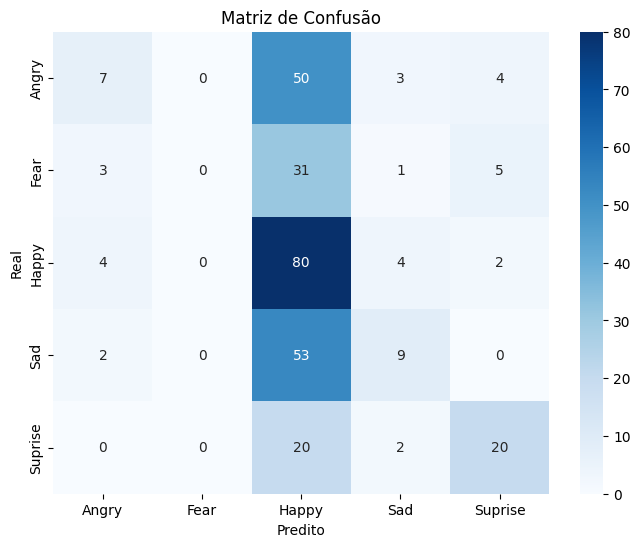

In [94]:
print(f'A rede atinge: {accuracy(resnet, testloader)}% de acurácia')
conf_mat = confusion_matrix(resnet, testloader)